In [1]:
import pickle as pkl
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib as mpl
import copy

mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['font.size']=22
mpl.rcParams['figure.figsize']=(16,16)
#mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['axes.linewidth']= 3.
mpl.rcParams['axes.titlepad'] = 20
#plt.rcParams['axes.linewidth']=5
plt.rcParams['xtick.major.size'] =15
plt.rcParams['ytick.major.size'] =15
plt.rcParams['xtick.minor.size'] =10
plt.rcParams['ytick.minor.size'] =10
plt.rcParams['xtick.major.width'] =5
plt.rcParams['ytick.major.width'] =5
plt.rcParams['xtick.minor.width'] =5
plt.rcParams['ytick.minor.width'] =5
mpl.rcParams['axes.titlepad'] = 20

%load_ext autoreload
%autoreload 2

In [2]:
def n_train_points(out, iters = 25, N = 20, initial_size = 5_000):
    n_points_av = []

    for i in range(N):
        n_points_av.append(out["out"][i]["n_train_points"])
        
    n_points_av = np.mean(n_points_av, axis = 0)
    n_points_av = n_points_av[:iters]
    n_points_av = np.insert(n_points_av, 0, initial_size)
    
    return n_points_av
    
def plotting_lists(out, string, loss_num, length_flag = False, iters = 25, N = 10):

    output_av = []
    output_std = []
    length = []
    for i in range(iters):
        
        min_len = np.inf
        output = []
        
        for j in range(N):
            
            output.append(out["out"][j][string][i][loss_num])
            
            if "test" not in string:
                min_check = len(out["out"][j][string][i][loss_num])
                min_len = min(min_len, min_check)
                
        
        if "test" not in string:
            for k in range(len(output)):
                output[k] = output[k][:min_len]

            output_av.extend(np.mean(output, axis = 0))
            output_std.extend(np.std(output, axis = 0))

            length.append(min_len)
        
        else:
            output_av.append(np.mean(output, axis = 0))
            output_std.append(np.std(output, axis = 0))
        
    if "test" in string:
        string = "test_loss_init" if "unscaled" not in string else "test_loss_init_unscaled"
        init_loss_av, init_loss_std = init_loss(out, string, loss_num, N) 
        output_av.insert(0, init_loss_av)
        output_std.insert(0, init_loss_std)   
        
        
    if length_flag:
        length = np.cumsum(length)
        length = np.insert(length, 0, 0)
        
        return np.array(output_av), np.array(output_std), length
    
    
    else:
        return np.array(output_av), np.array(output_std)
    
    
def init_loss(out, string, loss_num, N = 20):
    init_loss = []
    for i in range(N):
        init_loss.append(out["out"][i][string][loss_num])
        
    init_loss_std = np.std(init_loss)
    init_loss_av = np.mean(init_loss)
    
    return init_loss_av, init_loss_std


def collate_outputs(out, iters = 25, N = 10, initial_size = 5000, second_flux = True, unscale = False):
    plotting = {}
    
    string = "_unscaled" if unscale else ""
    
    plotting["n_points"] = n_train_points(out, iters = iters, N = N, initial_size = initial_size)
    
    (plotting["train_loss_1"],
     plotting["train_loss_1_std"],
     plotting["line_pos_1"]) = plotting_lists(
        out, 
        f"retrain_losses{string}",
        loss_num = 0,
        length_flag = True,
        iters = iters,
        N=N
    )
    
    plotting["test_loss_1"], plotting["test_loss_1_std"] = plotting_lists(
        out,
        f"post_test_loss{string}",
        loss_num = 0,
        iters = iters,
        N = N
    )
    
    if second_flux:
        (plotting["train_loss_2"],
         plotting["train_loss_2_std"],
         plotting["line_pos_2"]) = plotting_lists(
            out, 
            f"retrain_losses{string}",
            loss_num = 1,
            length_flag = True,
            iters = iters,
            N = N
        )

        plotting["test_loss_2"], plotting["test_loss_2_std"] = plotting_lists(
            out,
            f"post_test_loss{string}",
            loss_num = 1,
            iters = iters,
            N = N
        )
    
    return plotting

In [3]:
def plot_fig(
    plot_dicts_list,
    labels,
    flux_num = 1,
    baselines = None,
    train = True,
    test = True,
    save = None,
    y_lim = None,
    ncols = 2,
    subplot = True,
    figsize = None
    ):
    
    if subplot:
        mosaic = """
        A
        A
        B
        """
    else:
        mosaic = """
        A
        """
    
    if figsize:
        fig = plt.figure(figsize = figsize)
        
    else:
        fig = plt.figure()
    
    if test:
        sharex = True
    else:
        sharex = False
    
    ax_dict = fig.subplot_mosaic(mosaic, sharex=sharex)
    
    color_lists = ["red", "blue", "green", 
                   "magenta", "orange", "black", 
                   "grey", "lawngreen", "yellow", 
                   "aqua", "purple", "pink"]

    x_max = np.inf
    for i, plot_dict in enumerate(plot_dicts_list):
        
        train_test = ["train", "test"]
        if not train:
            train_test.remove("train")
        if not test:
            train_test.remove("test")
        
        for x in train_test:                      
            if x == "train":
                length = np.arange(len(plot_dict[f"train_loss_{flux_num}"]))
                linestyle = "--"
                label = f"{labels[i]}"
                marker = None
            else:
                #length = plot_dict[f"line_pos_{flux_num}"]
                length = np.arange(len(plot_dict["test_loss_1"]))
                linestyle = "solid"
                #label = f"Test Loss - {labels[i]}"
                label = f"{labels[i]}"
                marker = "o"
            
            ax_dict["A"].plot(
                length,
                plot_dict[f"{x}_loss_{flux_num}"],
                color = color_lists[i],
                linewidth = 4,
                label = label,
                linestyle = linestyle,
                marker = marker,
                markersize = 8,
            )

            ax_dict["A"].fill_between(
                length,
                plot_dict[f"{x}_loss_{flux_num}"] - plot_dict[f"{x}_loss_{flux_num}_std"],
                plot_dict[f"{x}_loss_{flux_num}"] + plot_dict[f"{x}_loss_{flux_num}_std"],  
                alpha = 0.1,
                color = color_lists[i],
                linewidth=4,
            )
            
            x_max = min(x_max, max(length))
        
            if subplot:
                ax_dict["B"].plot(plot_dict["n_points"], color = color_lists[i], marker = "o", linewidth=4, markersize = 11)
    
    if baselines:
        linestyles = [(0, (3, 10, 1, 10, 1, 10)), "dotted", "dashed", "dashdot"]
        
        for i, baseline in enumerate(baselines):
            ax_dict["A"].axhline(
                y = baseline[0], # Gotten from Average_Performance.ipynb
                linestyle = linestyles[i],
                linewidth=4, color = "tab:blue",
                label = f"{baseline[2]} Baseline",
                zorder = -1
            ) 
            
            ax_dict["A"].fill_between(
                np.arange(x_max),
                baseline[0] - baseline[1],
                baseline[0] + baseline[1],
                alpha = 0.05,
                color = "tab:blue",
                linewidth=4
                )
    
        
    #xlabel = "Epochs" if train else "Iterations"
    if train:
        ax_dict["A"].set_xlabel("Epochs", fontsize = 34)
        
    ax_dict["A"].set_ylabel("MSE", fontsize = 34)
    title = r"$q_{i,ITG}[GB]$" if flux_num == 1 else "$q_{e,ITG}[GB]$"
    
    ax_dict["A"].set_title(title, fontsize = 34)
    ax_dict["A"].legend(ncol = ncols, fontsize = 22, loc = 'best')
    ax_dict["A"].set_xlim(0, x_max)
    
    if y_lim is not None:
        ax_dict["A"].set_ylim(y_lim[0], y_lim[1])
    
    if subplot:
        ax_dict["B"].set_xlabel("AL Iterations", fontsize = 34)
        ax_dict["B"].set_ylabel("Training Points", fontsize = 34)
    
    fig.tight_layout()
    
    if save is not None:
        plt.savefig(save, dpi = 400)

In [4]:
with open("/share/rcifdata/jbarr/UKAEAGroupProject/PaperFinal/add_5Kbootstrapped_AL_lam_1_deep_classretrain_True.pkl", "rb") as f:
    out_add_5k = pkl.load(f)
    
with open("/share/rcifdata/jbarr/UKAEAGroupProject/PaperFinal/add_1Kbootstrapped_AL_lam_1_deep_classretrain_True.pkl", "rb") as f:
    out_add_1k = pkl.load(f)
    
with open("/share/rcifdata/jbarr/UKAEAGroupProject/PaperFinal/add_15Kbootstrapped_AL_lam_1_deep_classretrain_True.pkl", "rb") as f:
    out_add_15k = pkl.load(f)
    

In [5]:
with open("/share/rcifdata/jbarr/UKAEAGroupProject/PaperFinal/random_5Kbootstrapped_AL_lam_1_deep_classretrain_True.pkl", "rb") as f:
    out_random_5k = pkl.load(f)
    
with open("/share/rcifdata/jbarr/UKAEAGroupProject/PaperFinal/random_1Kbootstrapped_AL_lam_1_deep_classretrain_True.pkl", "rb") as f:
    out_random_1k = pkl.load(f)
    
with open("/share/rcifdata/jbarr/UKAEAGroupProject/PaperFinal/random_15Kbootstrapped_AL_lam_1_deep_classretrain_True.pkl", "rb") as f:
    out_random_15k = pkl.load(f)

In [6]:
with open("/share/rcifdata/jbarr/UKAEAGroupProject/PaperFinal/lead_5Kbootstrapped_AL_lam_1_deep_classretrain_True.pkl", "rb") as f:
    out_lead_5k = pkl.load(f)
    
with open("/share/rcifdata/jbarr/UKAEAGroupProject/PaperFinal/lead_1Kbootstrapped_AL_lam_1_deep_classretrain_True.pkl", "rb") as f:
    out_lead_1k = pkl.load(f)
    
with open("/share/rcifdata/jbarr/UKAEAGroupProject/PaperFinal/lead_15Kbootstrapped_AL_lam_1_deep_classretrain_True.pkl", "rb") as f:
    out_lead_15k = pkl.load(f)

In [7]:
with open("/share/rcifdata/jbarr/UKAEAGroupProject/PaperFinal/second_separate_3_bootstrapped_AL_lam_1_deep_classretrain_True.pkl", "rb") as f:
    out_second_5k = pkl.load(f)

In [8]:
with open("/share/rcifdata/jbarr/UKAEAGroupProject/PaperFinal/no_class_5Kbootstrapped_AL_lam_1_deep_classretrain_True.pkl", "rb") as f:
    out_no_class_5k = pkl.load(f)
    
with open("/share/rcifdata/jbarr/UKAEAGroupProject/PaperFinal/no_class_1K_bootstrapped_AL_lam_1_deep_classretrain_True.pkl", "rb") as f:
    out_no_class_1k = pkl.load(f)
    
with open("/share/rcifdata/jbarr/UKAEAGroupProject/PaperFinal/no_class_15K_bootstrapped_AL_lam_1_deep_classretrain_True.pkl", "rb") as f:
    out_no_class_15k = pkl.load(f)

In [9]:
with open("/share/rcifdata/jbarr/UKAEAGroupProject/PaperFinal/long_add_bootstrapped_AL_lam_1_deep_classretrain_True.pkl", "rb") as f:
    out_long_add = pkl.load(f)
    
with open("/share/rcifdata/jbarr/UKAEAGroupProject/PaperFinal/long_add_2_bootstrapped_AL_lam_1_deep_classretrain_True.pkl", "rb") as f:
    out_long_add_2 = pkl.load(f)
    

with open("/share/rcifdata/jbarr/UKAEAGroupProject/PaperFinal/long_lead_bootstrapped_AL_lam_1_deep_classretrain_True.pkl", "rb") as f:
    out_long_lead = pkl.load(f)
    
with open("/share/rcifdata/jbarr/UKAEAGroupProject/PaperFinal/long_lead_2_bootstrapped_AL_lam_1_deep_classretrain_True.pkl", "rb") as f:
    out_long_lead_2 = pkl.load(f)

In [10]:
out_add = copy.deepcopy(out_add_5k)
out_lead = copy.deepcopy(out_lead_5k)

out_add["out"].extend(out_long_add["out"])
out_add["out"].extend(out_long_add_2["out"])

out_lead["out"].extend(out_long_lead["out"])
out_lead["out"].extend(out_long_lead_2["out"])

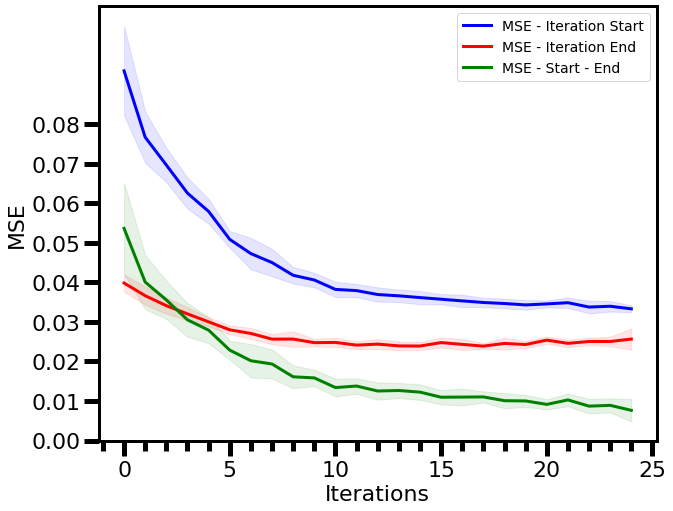

In [11]:
start = []
end = []

start_std = []
end_std = []

for i in range(25):
    start_temp = []
    end_temp = []
    for j in range(10):
        train_loss_1 = out_lead_5k["out"][j]["retrain_losses"][i][0]
        
        start_temp.append(train_loss_1[0])
        end_temp.append(train_loss_1[-1])
    
    start.append(np.mean(start_temp))
    end.append(np.mean(end_temp))
    
    start_std.append(np.std(start_temp))
    end_std.append(np.std(end_temp))
    
start = np.array(start)
end = np.array(end)
start_std = np.array(start_std)
end_std = np.array(end_std)
    
plt.figure(figsize = (10,8))

plt.plot(start, "blue", label = "MSE - Iteration Start", linewidth=3)
plt.plot(end, "red", linewidth=3, label = "MSE - Iteration End")

plt.fill_between(
    list(range(len(start))),
    start - start_std,
    start + start_std,  
    alpha = 0.1,
    color = "blue",
)

plt.fill_between(
    list(range(len(start))),
    end - end_std,
    end + end_std,  
    alpha = 0.1,
    color = "red",
)

plt.plot(start - end, "green", linewidth = 3, label = "MSE - Start - End")

combined_std = np.array([np.sqrt(start_std[i]**2 + end_std[i]**2) for i in range(len(start_std))])

plt.fill_between(
    list(range(len(start))),
    start - end - combined_std,
    start - end + combined_std,  
    alpha = 0.1,
    color = "green",
)

plt.legend(fontsize = 14);
plt.xlabel("Iterations")
plt.ylabel("MSE");
plt.yticks(np.arange(0, 0.09, step=0.01));

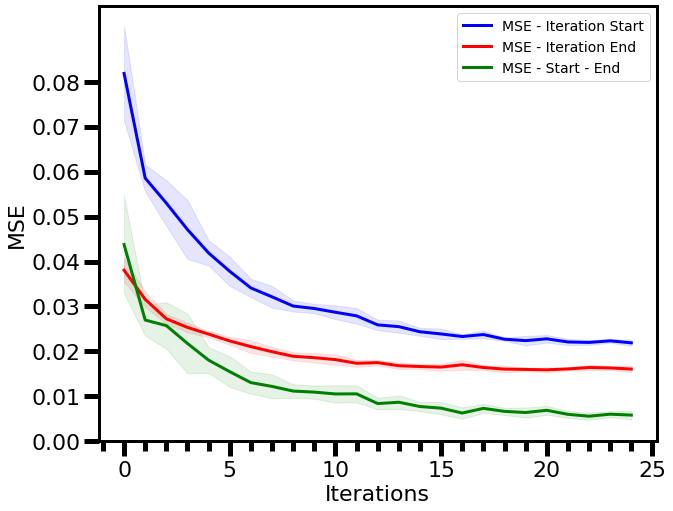

In [117]:
start = []
end = []

start_std = []
end_std = []

for i in range(25):
    start_temp = []
    end_temp = []
    for j in range(10):
        train_loss_1 = out_random_5k["out"][j]["retrain_losses"][i][0]
        
        start_temp.append(train_loss_1[0])
        end_temp.append(train_loss_1[-1])
    
    start.append(np.mean(start_temp))
    end.append(np.mean(end_temp))
    
    start_std.append(np.std(start_temp))
    end_std.append(np.std(end_temp))
    
start = np.array(start)
end = np.array(end)
start_std = np.array(start_std)
end_std = np.array(end_std)
    
plt.figure(figsize = (10,8))

plt.plot(start, "blue", label = "MSE - Iteration Start", linewidth=3)
plt.plot(end, "red", linewidth=3, label = "MSE - Iteration End")

plt.fill_between(
    list(range(len(start))),
    start - start_std,
    start + start_std,  
    alpha = 0.1,
    color = "blue",
)

plt.fill_between(
    list(range(len(start))),
    end - end_std,
    end + end_std,  
    alpha = 0.1,
    color = "red",
)

plt.plot(start - end, "green", linewidth = 3, label = "MSE - Start - End")

combined_std = np.array([np.sqrt(start_std[i]**2 + end_std[i]**2) for i in range(len(start_std))])

plt.fill_between(
    list(range(len(start))),
    start - end - combined_std,
    start - end + combined_std,  
    alpha = 0.1,
    color = "green",
)

plt.legend(fontsize = 14);
plt.xlabel("Iterations")
plt.ylabel("MSE");
plt.yticks(np.arange(0, 0.09, step=0.01));

In [48]:
out_add_5k["out"][0].keys()

dict_keys(['train_loss_init', 'test_loss_init', 'test_loss_init_unscaled', 'retrain_losses', 'retrain_val_losses', 'retrain_losses_unscaled', 'retrain_val_losses_unscaled', 'post_test_loss', 'post_test_loss_unscaled', 'n_train_points', 'mse_before', 'mse_after', 'd_mse', 'd_uncert', 'd_novel_uncert', 'novel_uncert_before', 'novel_uncert_after', 'holdout_pred_before', 'holdout_pred_after', 'holdout_ground_truth', 'class_train_loss_init', 'class_test_loss_init', 'class_train_acc_init', 'class_test_acc_init', 'class_precision_init', 'class_recall_init', 'class_f1_init', 'class_auc_init', 'class_train_loss', 'class_val_loss', 'class_missed_loss', 'class_train_acc', 'class_val_acc', 'class_missed_acc', 'holdout_class_acc', 'holdout_class_loss', 'holdout_class_precision', 'holdout_class_recall', 'holdout_class_f1', 'holdout_class_auc', 'class_retrain_iterations'])

In [49]:
out_add_5k["out"][0]["holdout_class_acc"]

[0.94602, 0.94024, 0.94214]

In [50]:
out_add_5k["out"][0]["holdout_class_precision"]

[0.9217174053853984, 0.9285298116139056, 0.9292657107111923]

In [51]:
out_add_5k["out"][0]["holdout_class_recall"]

[0.8431521923142035, 0.8093787032334518, 0.8173353648213983]

In [52]:
out_add_5k["out"][0]["holdout_class_f1"]

[0.880686088148181, 0.8648697539797395, 0.8697140283719883]

In [12]:
add_5k = collate_outputs(out_add_5k, iters = 25, N = 10, initial_size = 5_000, second_flux = True, unscale = True)
add_1k = collate_outputs(out_add_1k, iters = 25, N = 10, initial_size = 1_000, second_flux = True, unscale = True)
add_15k = collate_outputs(out_add_15k, iters = 25, N = 10, initial_size = 15_000, second_flux = True, unscale = True)

In [13]:
random_5k = collate_outputs(out_random_5k, iters = 25, N = 10, initial_size = 5_000, second_flux = True, unscale = True)
random_1k = collate_outputs(out_random_1k, iters = 25, N = 10, initial_size = 1_000, second_flux = True, unscale = True)
random_15k = collate_outputs(out_random_15k, iters = 25, N = 10, initial_size = 15_000, second_flux = True, unscale = True)

In [14]:
lead_5k = collate_outputs(out_lead_5k, iters = 25, N = 10, initial_size = 5_000, second_flux = True, unscale = True)
lead_1k = collate_outputs(out_lead_1k, iters = 25, N = 10, initial_size = 1_000, second_flux = True, unscale = True)
lead_15k = collate_outputs(out_lead_15k, iters = 25, N = 10, initial_size = 15_000, second_flux = True, unscale = True)

In [15]:
second_5k = collate_outputs(out_second_5k, iters = 25, N = 10, initial_size = 5_000, second_flux = False, unscale = True)

In [14]:
second_5k['n_points']

array([ 5000.,  5485.,  5970.,  6455.,  6940.,  7425.,  7910.,  8395.,
        8880.,  9365.,  9850., 10335., 10820., 11305., 11790., 12275.,
       12760., 13245., 13730., 14215., 14700., 15185., 15670., 16155.,
       16640., 17125.])

In [16]:
no_class_5k = collate_outputs(out_no_class_5k, iters = 25, N = 10, initial_size = 5_000, second_flux = True, unscale = True)
no_class_1k = collate_outputs(out_no_class_1k, iters = 25, N = 10, initial_size = 5_000, second_flux = True, unscale = True)
no_class_15k = collate_outputs(out_no_class_15k, iters = 25, N = 10, initial_size = 5_000, second_flux = True, unscale = True)

In [17]:
add = collate_outputs(out_add, iters = 25, N = 30, initial_size = 5_000, second_flux = True, unscale = True)
lead = collate_outputs(out_lead, iters = 25, N = 30, initial_size = 5_000, second_flux = True, unscale = True)

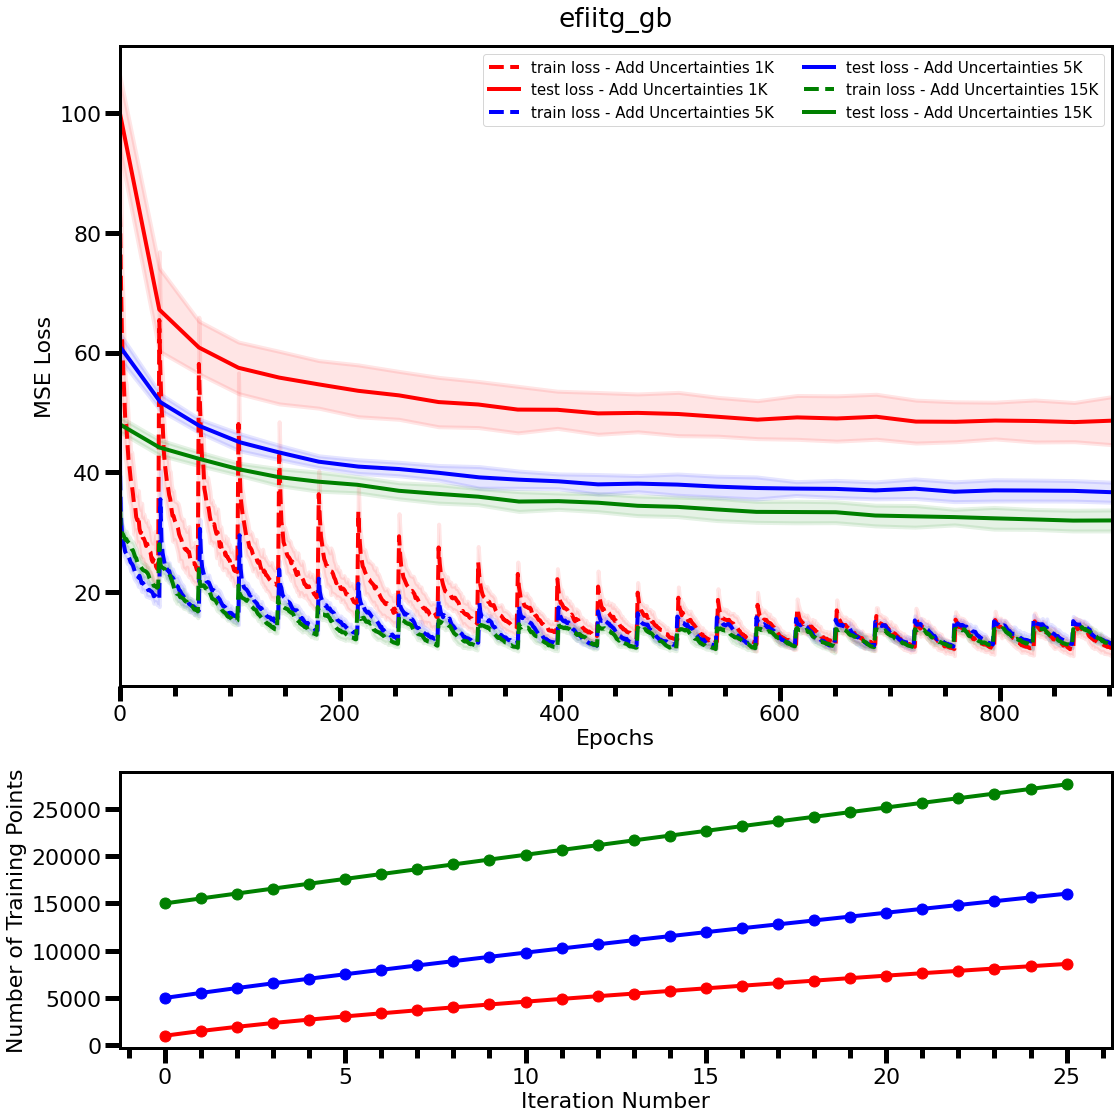

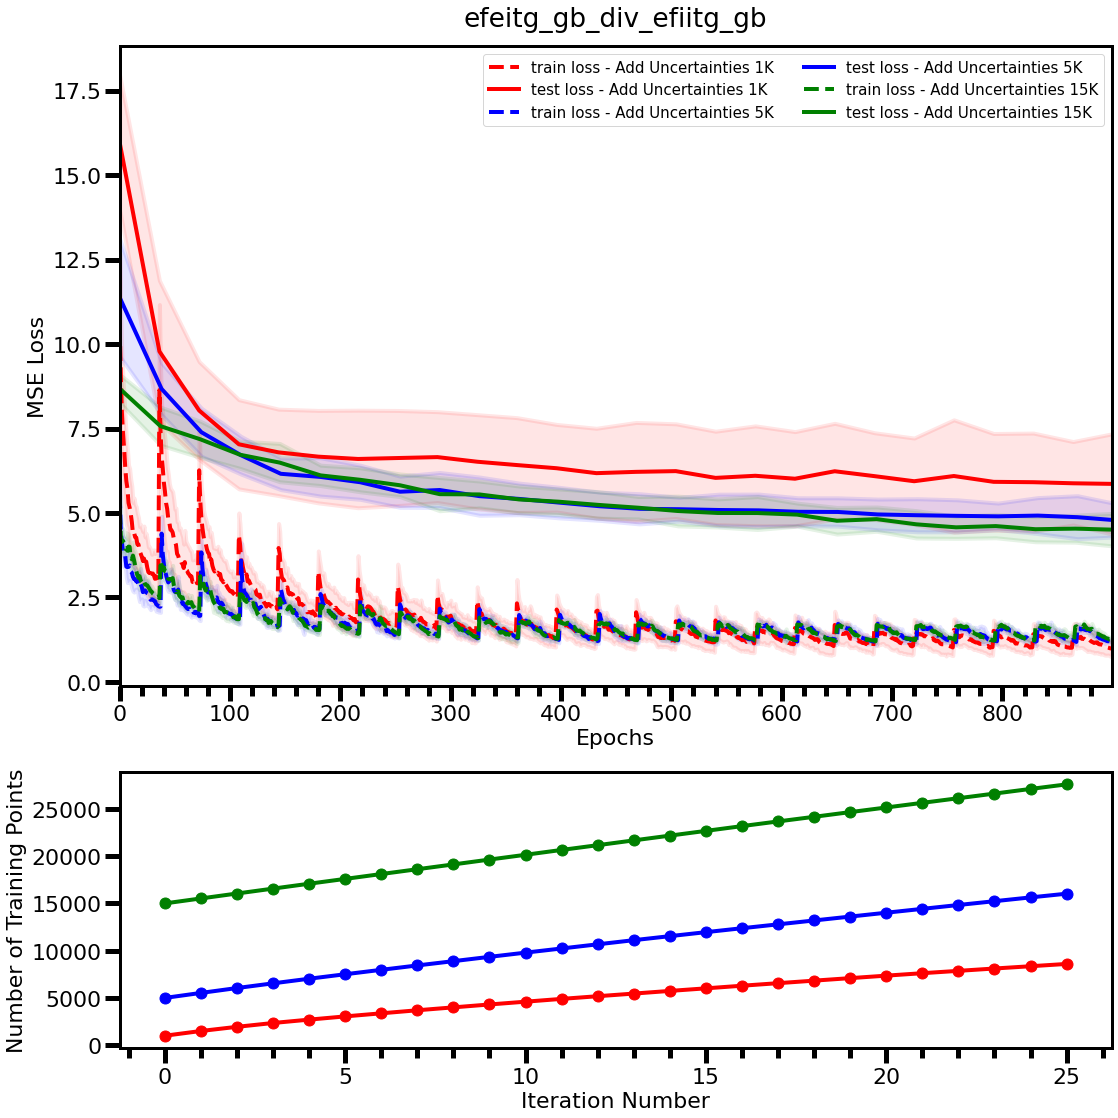

In [13]:
plot_fig(
    [add_1k, add_5k, add_15k],
    ["Add Uncertainties 1K", "Add Uncertainties 5K", "Add Uncertainties 15K"],
    flux_num = 1
)

plot_fig(
    [add_1k, add_5k, add_15k],
    ["Add Uncertainties 1K", "Add Uncertainties 5K", "Add Uncertainties 15K"],
    flux_num = 2
)

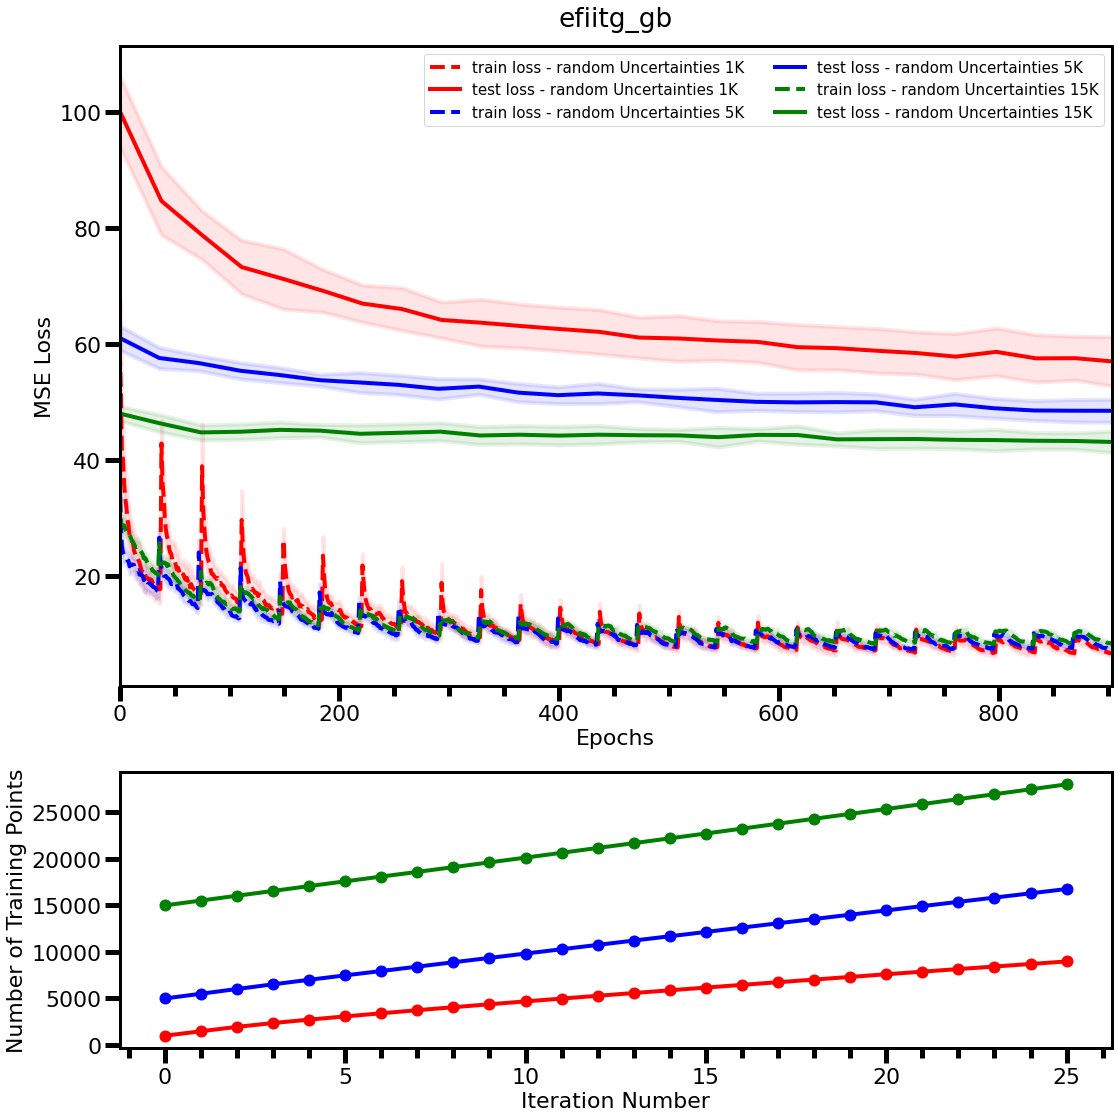

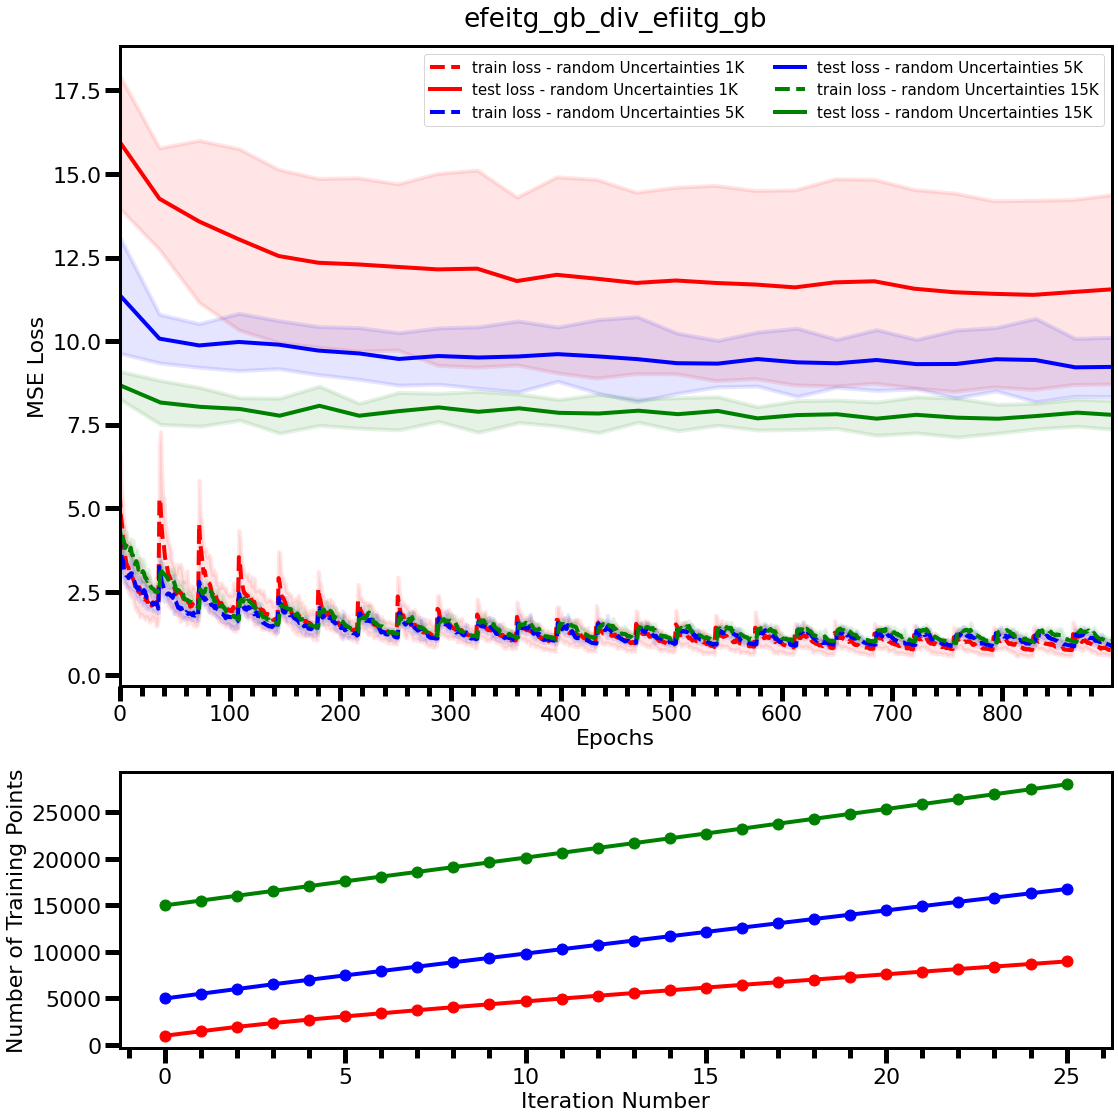

In [14]:
plot_fig(
    [random_1k, random_5k, random_15k],
    ["random Uncertainties 1K", "random Uncertainties 5K", "random Uncertainties 15K"],
    flux_num = 1
)

plot_fig(
    [random_1k, random_5k, random_15k],
    ["random Uncertainties 1K", "random Uncertainties 5K", "random Uncertainties 15K"],
    flux_num = 2
)

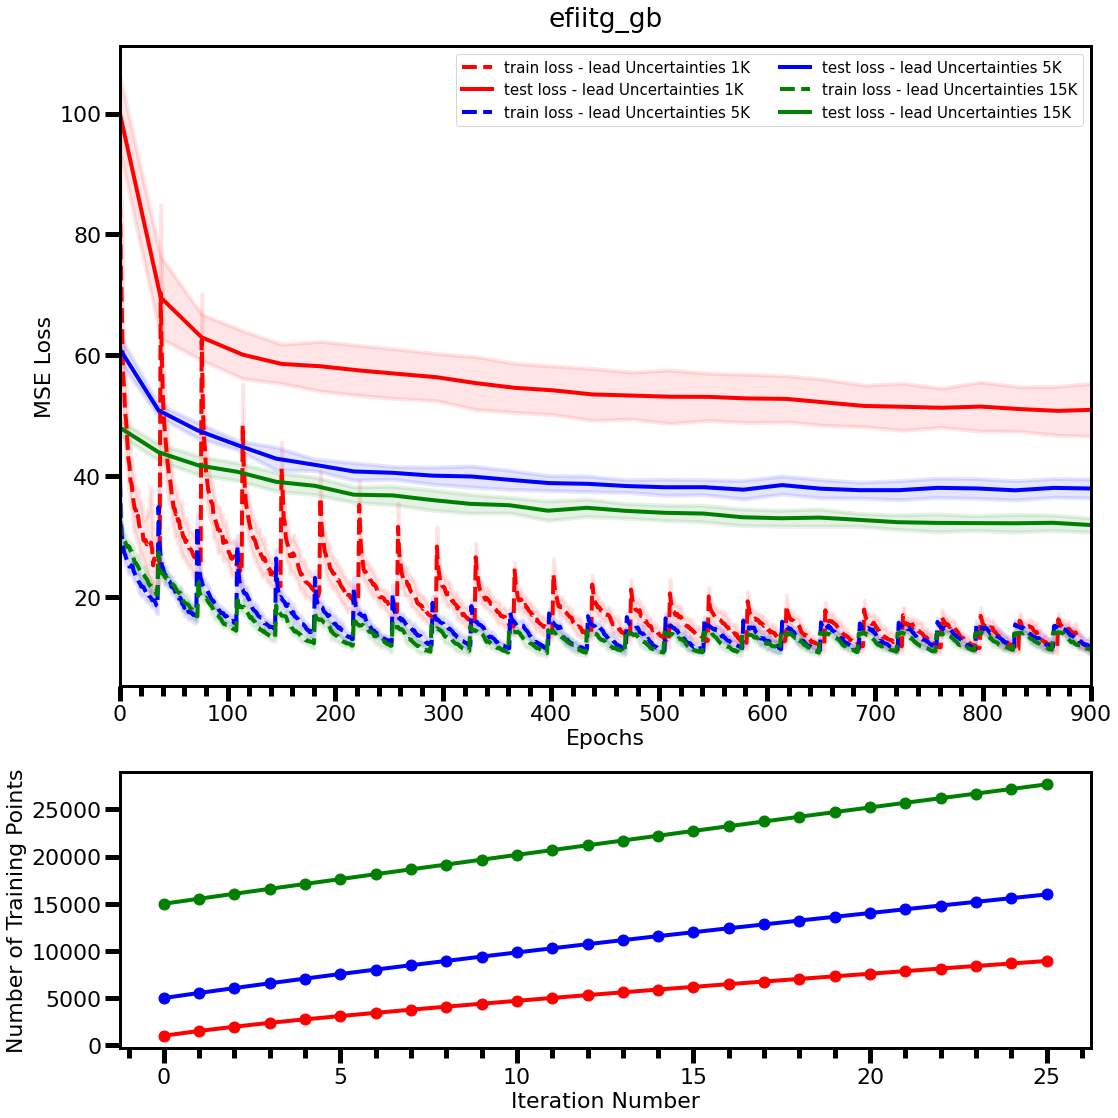

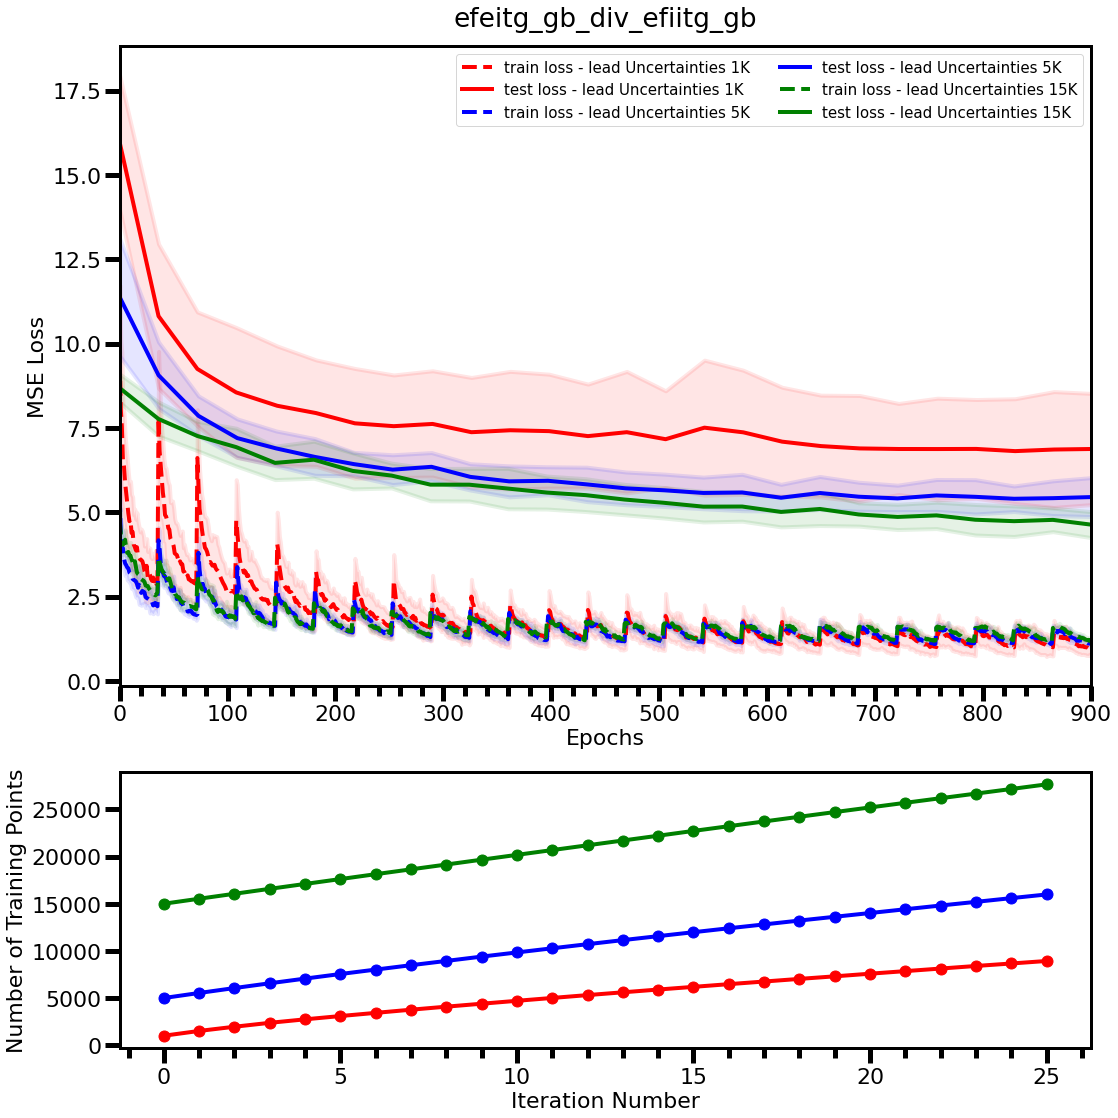

In [15]:
plot_fig(
    [lead_1k, lead_5k, lead_15k],
    ["lead Uncertainties 1K", "lead Uncertainties 5K", "lead Uncertainties 15K"],
    flux_num = 1
)

plot_fig(
    [lead_1k, lead_5k, lead_15k],
    ["lead Uncertainties 1K", "lead Uncertainties 5K", "lead Uncertainties 15K"],
    flux_num = 2
)

In [44]:
add_5k["n_points"]

array([ 5000. ,  5529. ,  6045.7,  6543.1,  7031.3,  7504.5,  7972.9,
        8436.6,  8889.2,  9345. ,  9792.4, 10231.9, 10671.3, 11109.5,
       11534.9, 11958.8, 12373.9, 12783.8, 13195.3, 13606.2, 14015.5,
       14423. , 14831.8, 15234.2, 15634.8, 16028.9])

In [24]:
add_1k["n_points"]

array([1000. , 1500.9, 1942.1, 2347.4, 2703.6, 3045. , 3371. , 3693.9,
       4000.7, 4306.2, 4602.7, 4897.6, 5181.1, 5459.2, 5741.2, 6014.1,
       6290.6, 6560.7, 6828.5, 7094. , 7357.2, 7616.2, 7864.9, 8112.6,
       8352.9, 8596.4])

In [25]:
add_15k["n_points"]

array([15000. , 15525.1, 16046.4, 16566.3, 17082.4, 17593.3, 18106.3,
       18616.2, 19124.3, 19638.5, 20145.1, 20657.1, 21160.3, 21667.5,
       22171.8, 22673.3, 23177.2, 23673.4, 24162.8, 24658.7, 25148.4,
       25640.7, 26129.3, 26619.7, 27111.4, 27593.6])

In [29]:
print("1st:",no_class_5k["test_loss_1"][7], no_class_5k["test_loss_1_std"][7]," 2nd:", no_class_5k["test_loss_2"][7], no_class_5k["test_loss_2_std"][7])
print("1st:",random_5k["test_loss_1"][7], random_5k["test_loss_1_std"][7]," 2nd:", random_5k["test_loss_2"][7], random_5k["test_loss_2_std"][7])
print("1st:",lead_5k["test_loss_1"][7], lead_5k["test_loss_1_std"][7]," 2nd:", lead_5k["test_loss_2"][7], lead_5k["test_loss_2_std"][7])
print("1st:",add_5k["test_loss_1"][7], add_5k["test_loss_1_std"][7]," 2nd:",add_5k["test_loss_2"][7], add_5k["test_loss_2_std"][7])

1st: 57.283200944183704 3.4831382618543603  2nd: 8.284972524771575 0.8832895892997473
1st: 52.96963447481845 1.6782499630158885  2nd: 9.46400336084093 0.7857336096439125
1st: 40.53048013224217 1.0554013549185381  2nd: 6.261994199120389 0.4412198548472632
1st: 40.53879895443538 1.1275504469948898  2nd: 5.629926621802541 0.46135445304944633


In [28]:
print("1st:",no_class_1k["test_loss_1"][-1], no_class_1k["test_loss_1_std"][-1]," 2nd:", no_class_1k["test_loss_2"][-1], no_class_1k["test_loss_2_std"][-1])
print("1st:",random_1k["test_loss_1"][-1], random_1k["test_loss_1_std"][-1]," 2nd:", random_1k["test_loss_2"][-1], random_1k["test_loss_2_std"][-1])
print("1st:",lead_1k["test_loss_1"][-1], lead_1k["test_loss_1_std"][-1]," 2nd:", lead_1k["test_loss_2"][-1], lead_1k["test_loss_2_std"][-1])
print("1st:",add_1k["test_loss_1"][-1], add_1k["test_loss_1_std"][-1]," 2nd:",add_1k["test_loss_2"][-1], add_1k["test_loss_2_std"][-1])

1st: 64.25622652317695 4.752762059386361  2nd: 8.261938912993807 1.2701922902092913
1st: 56.96525476212106 4.296937915928139  2nd: 11.54982036459803 2.833716954196003
1st: 50.99313929374612 4.43634923818776  2nd: 6.8750016246775 1.6452400567926813
1st: 48.636102613192115 4.051729052571691  2nd: 5.861616582089085 1.486191212852388


In [40]:
print("1st:",no_class_15k["test_loss_1"][-1], no_class_15k["test_loss_1_std"][-1]," 2nd:", no_class_15k["test_loss_2"][-1], no_class_15k["test_loss_2_std"][-1])
print("1st:",random_15k["test_loss_1"][-1], random_15k["test_loss_1_std"][-1]," 2nd:", random_15k["test_loss_2"][-1], random_15k["test_loss_2_std"][-1])
print("1st:",lead_15k["test_loss_1"][-1], lead_15k["test_loss_1_std"][-1]," 2nd:", lead_15k["test_loss_2"][-1], lead_15k["test_loss_2_std"][-1])
print("1st:",add_15k["test_loss_1"][-1], add_15k["test_loss_1_std"][-1]," 2nd:",add_15k["test_loss_2"][-1], add_15k["test_loss_2_std"][-1])

1st: 49.3431397603144 2.4582245414677413  2nd: 6.905948677238096 0.5401288671411937
1st: 43.11720315701018 1.8728410993638684  2nd: 7.781581368119679 0.4335400528474174
1st: 31.87845134940178 1.1590250159186701  2nd: 4.62925862031125 0.38517638299079304
1st: 31.948771992695704 1.7551550343508115  2nd: 4.505422331233856 0.4864771805153491


In [20]:
second_5k.keys()
second_5k["train_loss_2"] = second_5k["train_loss_1"]
second_5k["train_loss_2_std"] = second_5k["train_loss_1_std"]
second_5k["test_loss_2"] = second_5k["test_loss_1"]
second_5k["test_loss_2_std"] = second_5k["test_loss_1_std"]
second_5k["line_pos_2"] = second_5k["line_pos_1"]

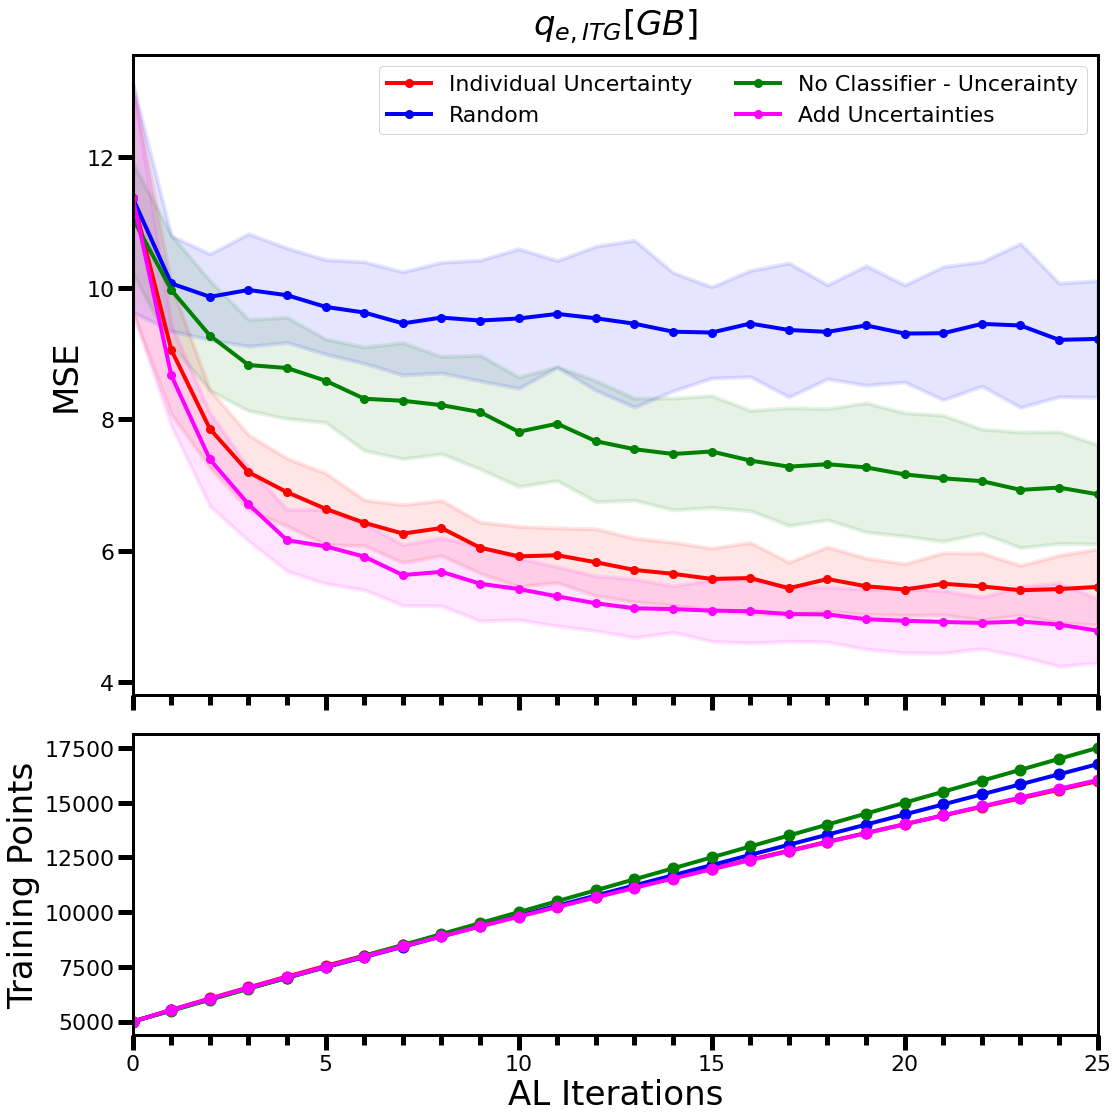

In [22]:
# plot_fig(
#     [add, lead, random_5k, no_class_5k],
#     ["Add Uncertainties", "Individual Uncertainty", "Random Sampling", "No Classifier"],
#     flux_num = 1,
#     y_lim = (5, 70),
#     ncols = 2,
#     #save = "Flux_1.png"
#     #train = False,
#     #test = False
# )

# plot_fig(
#     [lead_5k, random_5k, no_class_5k, add_5k], # add_5k,
#     ["Individual Uncertainty", "Random", "No Classifier - Uncertainty", "Add Uncertainties"], #"Add Uncertainties",
#     flux_num = 1,
#     #y_lim = (5, 70),
#     ncols = 2,
#     save = "Flux_1_train.png",
#     train = True,
#     subplot = True,
#     figsize = (16,16),
#     test = False
# )


plot_fig(
    [lead_5k, random_5k, no_class_5k, add_5k,],
    ["Individual Uncertainty", "Random", "No Classifier - Uncerainty", "Add Uncertainties"],
    flux_num = 2,
    #save = "Flux_2.png",
    train = False,
    figsize = (16,16),
    test = True,
)

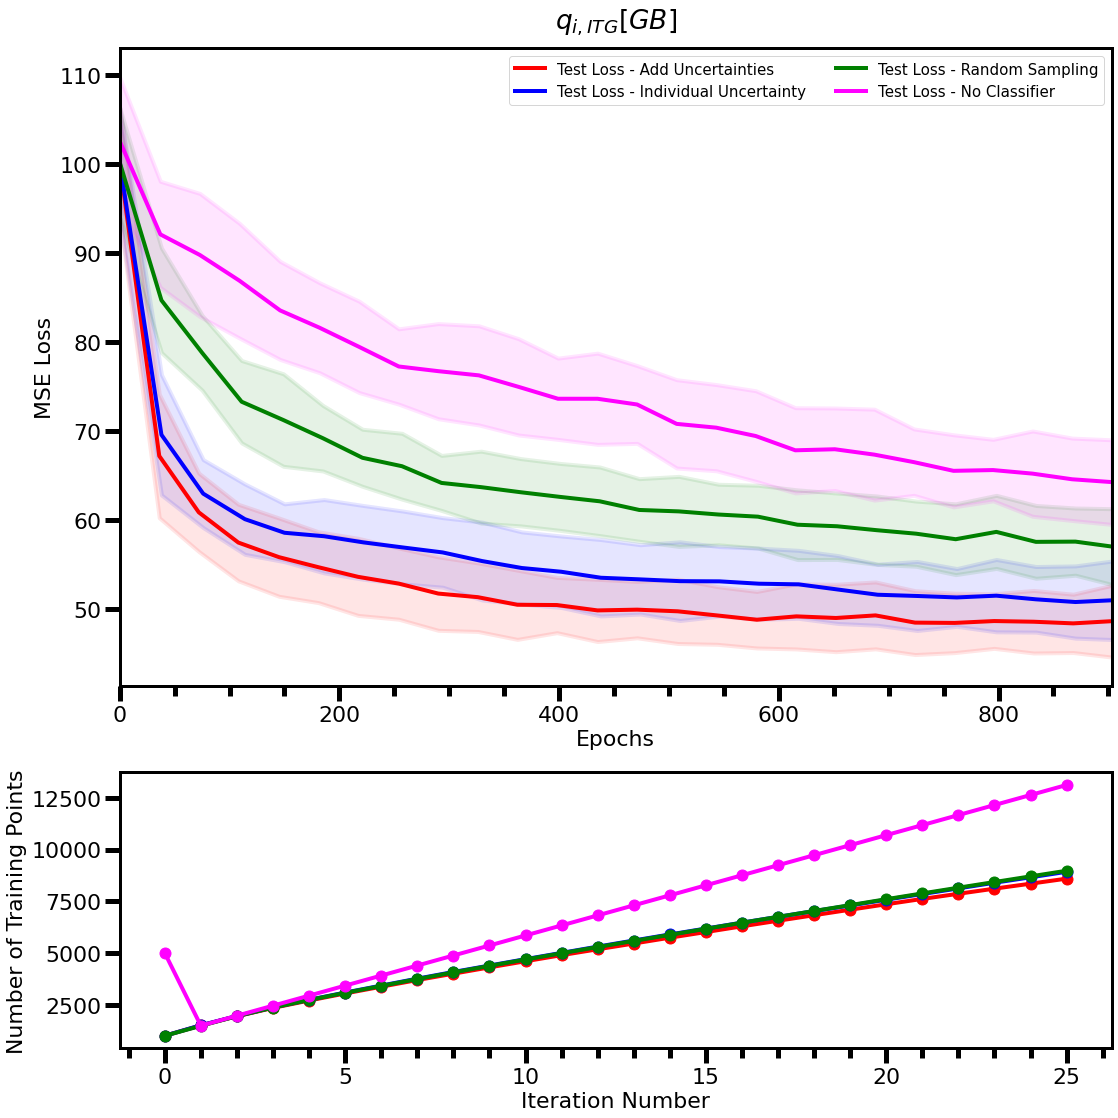

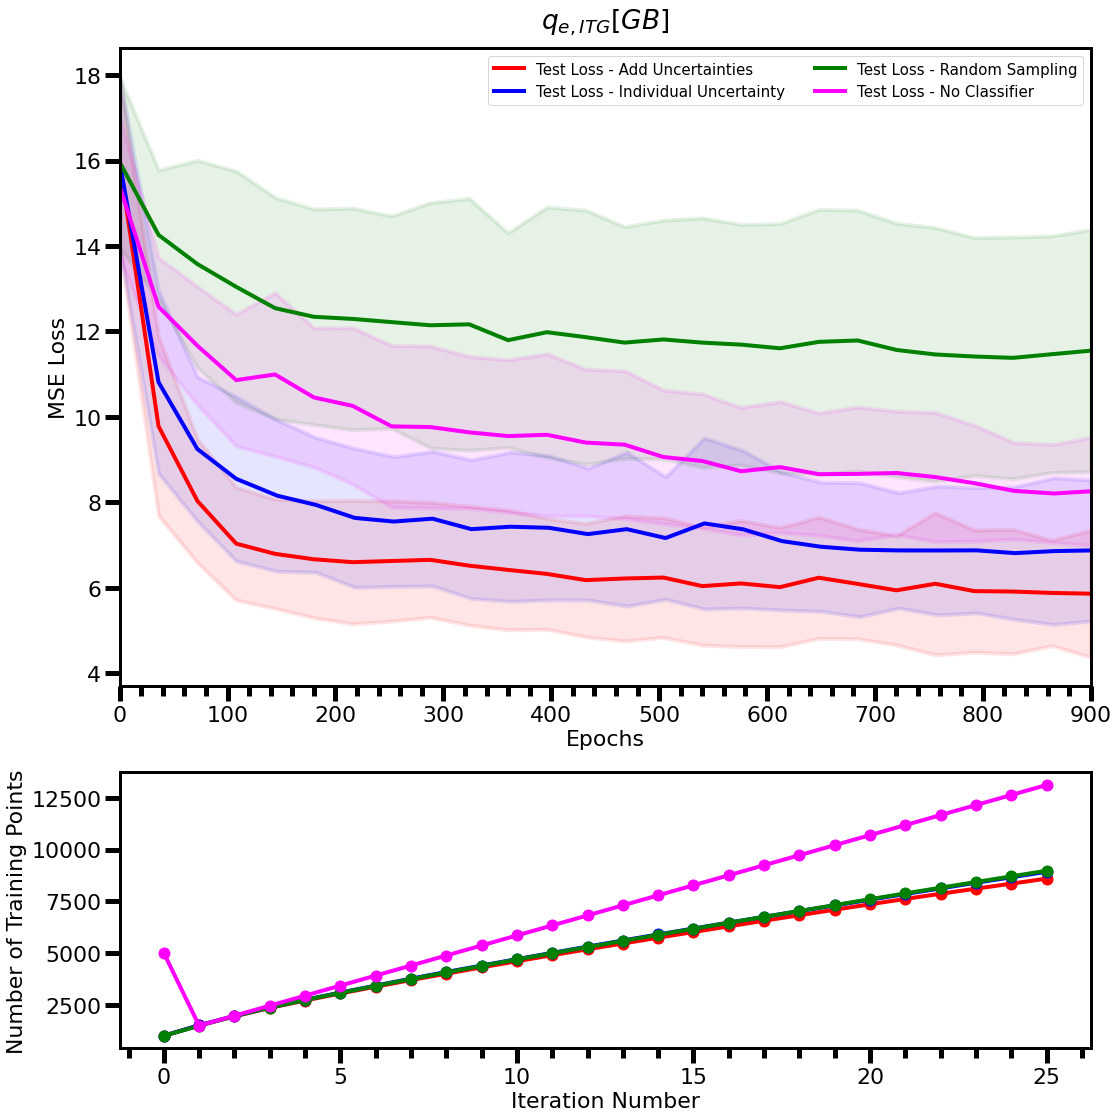

In [41]:
plot_fig(
    [add_1k, lead_1k, random_1k, no_class_1k],
    ["Add Uncertainties", "Individual Uncertainty", "Random Sampling", "No Classifier"],
    flux_num = 1,
    #y_lim = (5, 70),
    ncols = 2,
    save = "Flux_1.png",
    train = False,
    #test = False
)


plot_fig(
    [add_1k, lead_1k, random_1k, no_class_1k],
    ["Add Uncertainties", "Individual Uncertainty", "Random Sampling", "No Classifier"],
    flux_num = 2,
    save = "Flux_2.png",
    train = False,
    #test = False
)

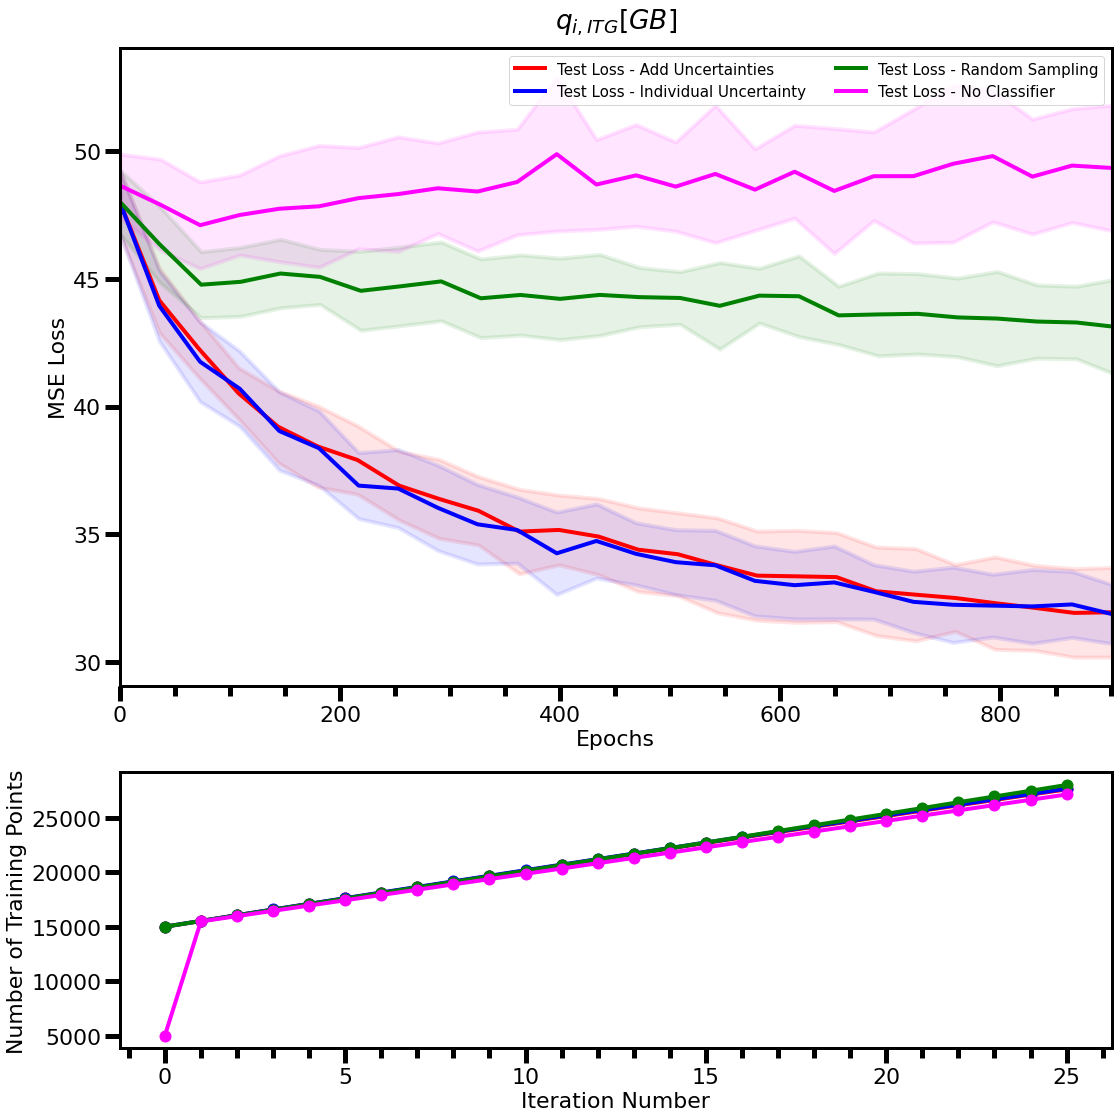

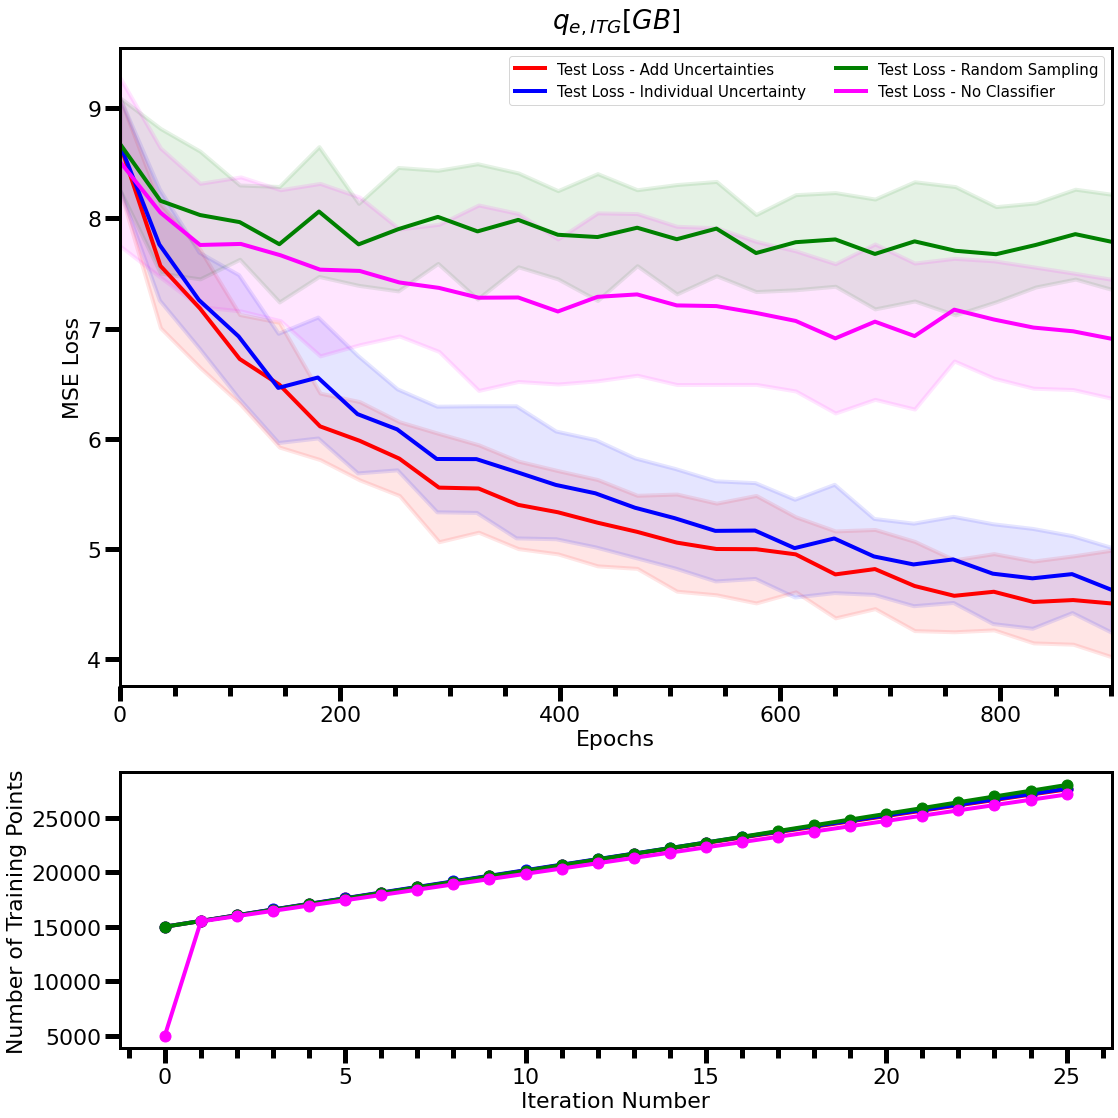

In [42]:
plot_fig(
    [add_15k, lead_15k, random_15k, no_class_15k],
    ["Add Uncertainties", "Individual Uncertainty", "Random Sampling", "No Classifier"],
    flux_num = 1,
    #y_lim = (5, 70),
    ncols = 2,
    save = "Flux_1.png",
    train = False,
    #test = False
)


plot_fig(
    [add_15k, lead_15k, random_15k, no_class_15k],
    ["Add Uncertainties", "Individual Uncertainty", "Random Sampling", "No Classifier"],
    flux_num = 2,
    save = "Flux_2.png",
    train = False,
    #test = False
)

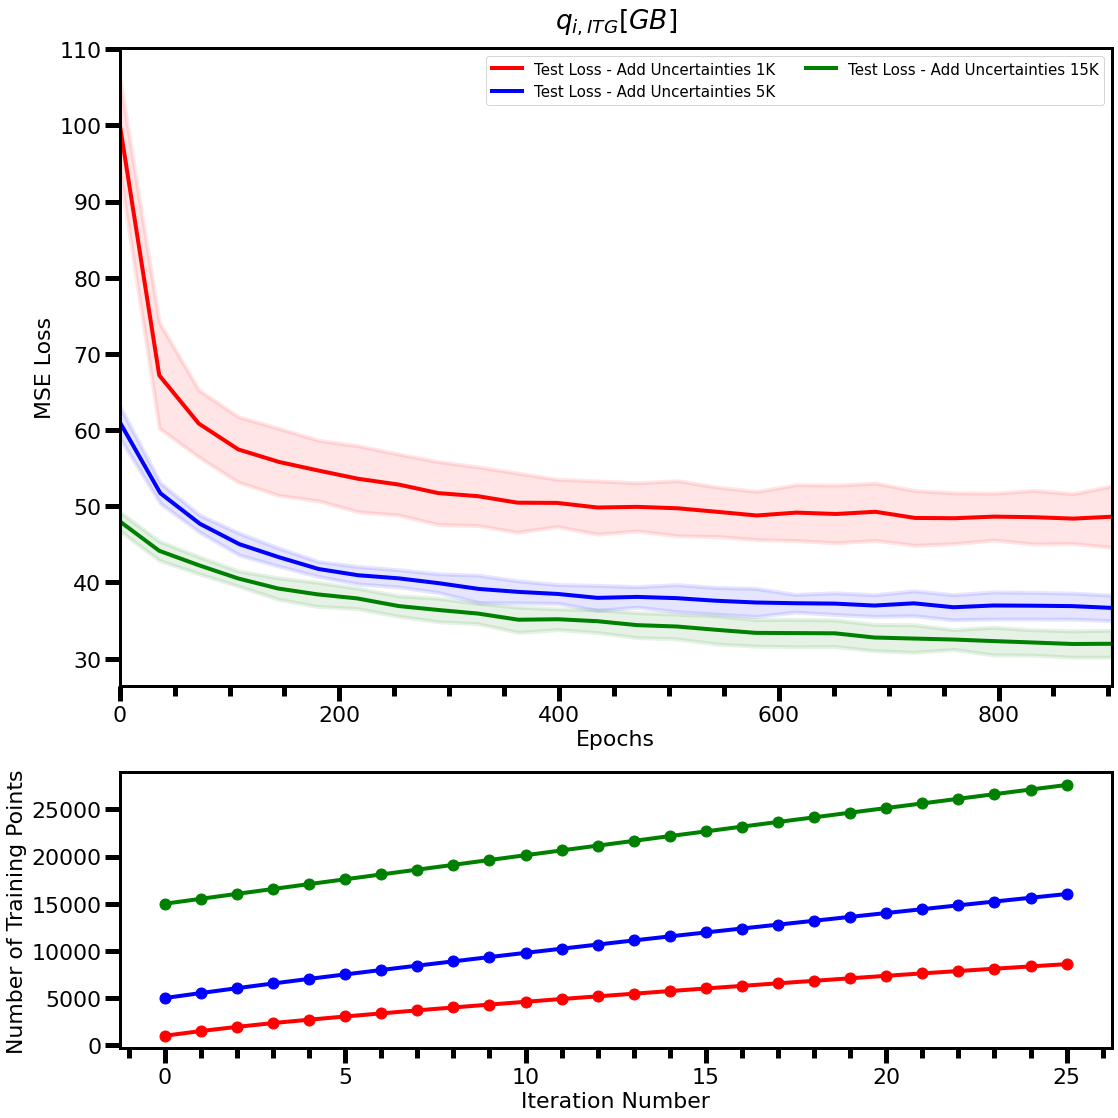

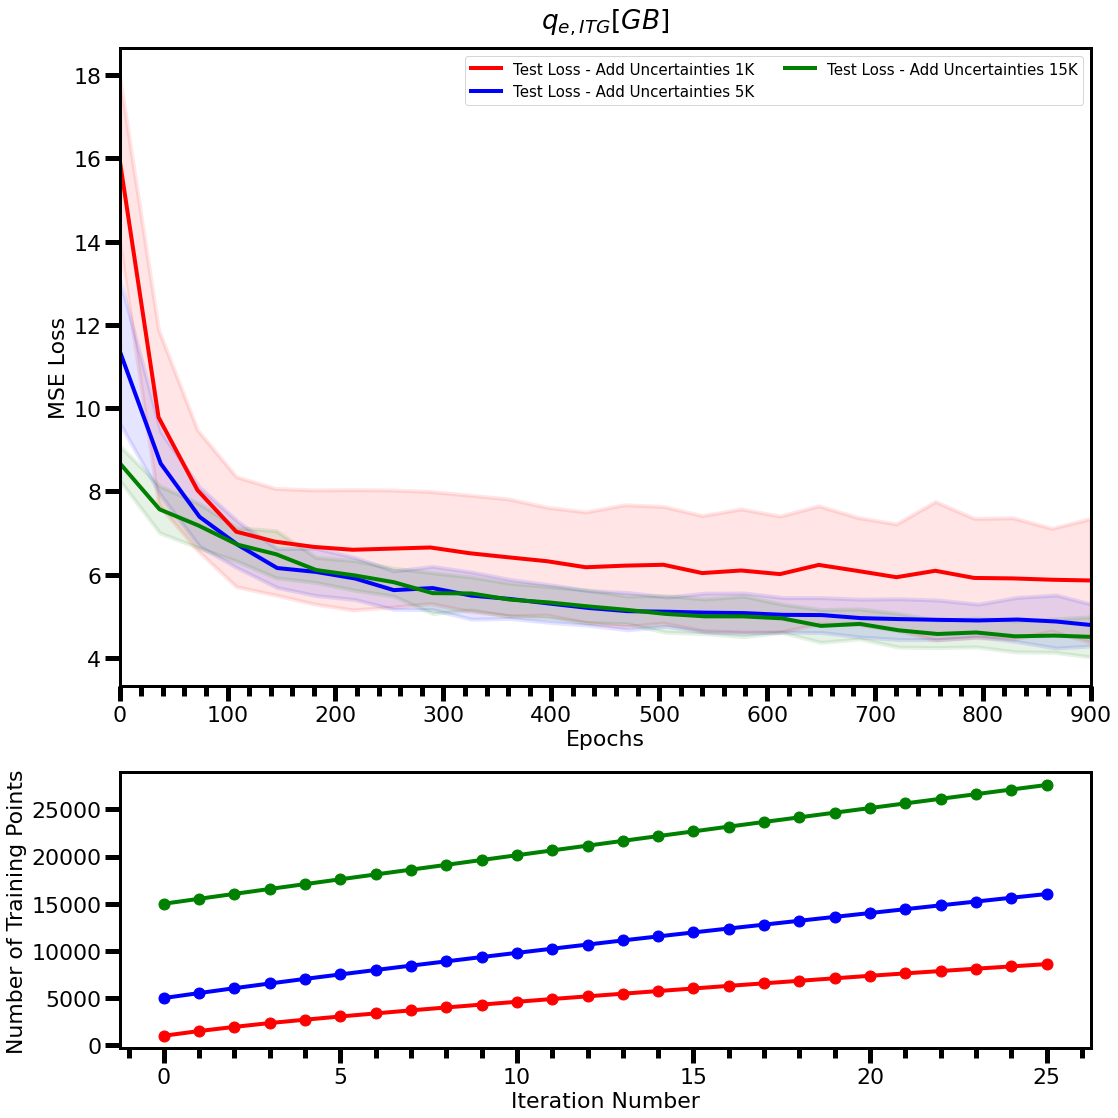

In [43]:
plot_fig(
    [add_1k, add_5k, add_15k],
    ["Add Uncertainties 1K", "Add Uncertainties 5K", "Add Uncertainties 15K"],
    flux_num = 1,
    #y_lim = (5, 70),
    ncols = 2,
    #save = "Flux_1.png",
    train = False,
    #test = False
)


plot_fig(
    [add_1k, add_5k, add_15k],
    ["Add Uncertainties 1K", "Add Uncertainties 5K", "Add Uncertainties 15K"],
    flux_num = 2,
    #y_lim = (5, 70),
    ncols = 2,
    #save = "Flux_1.png",
    train = False,
    #test = False
)

## Hyperparameter Scan

In [25]:
alphas_out = []

for i in range(1, 11):
    with open(f"/share/rcifdata/jbarr/UKAEAGroupProject/PaperFinal/alpha_{i}bootstrapped_AL_lam_1_deep_classretrain_True.pkl", "rb") as f:
        out = pkl.load(f)
        alphas_out.append(out)

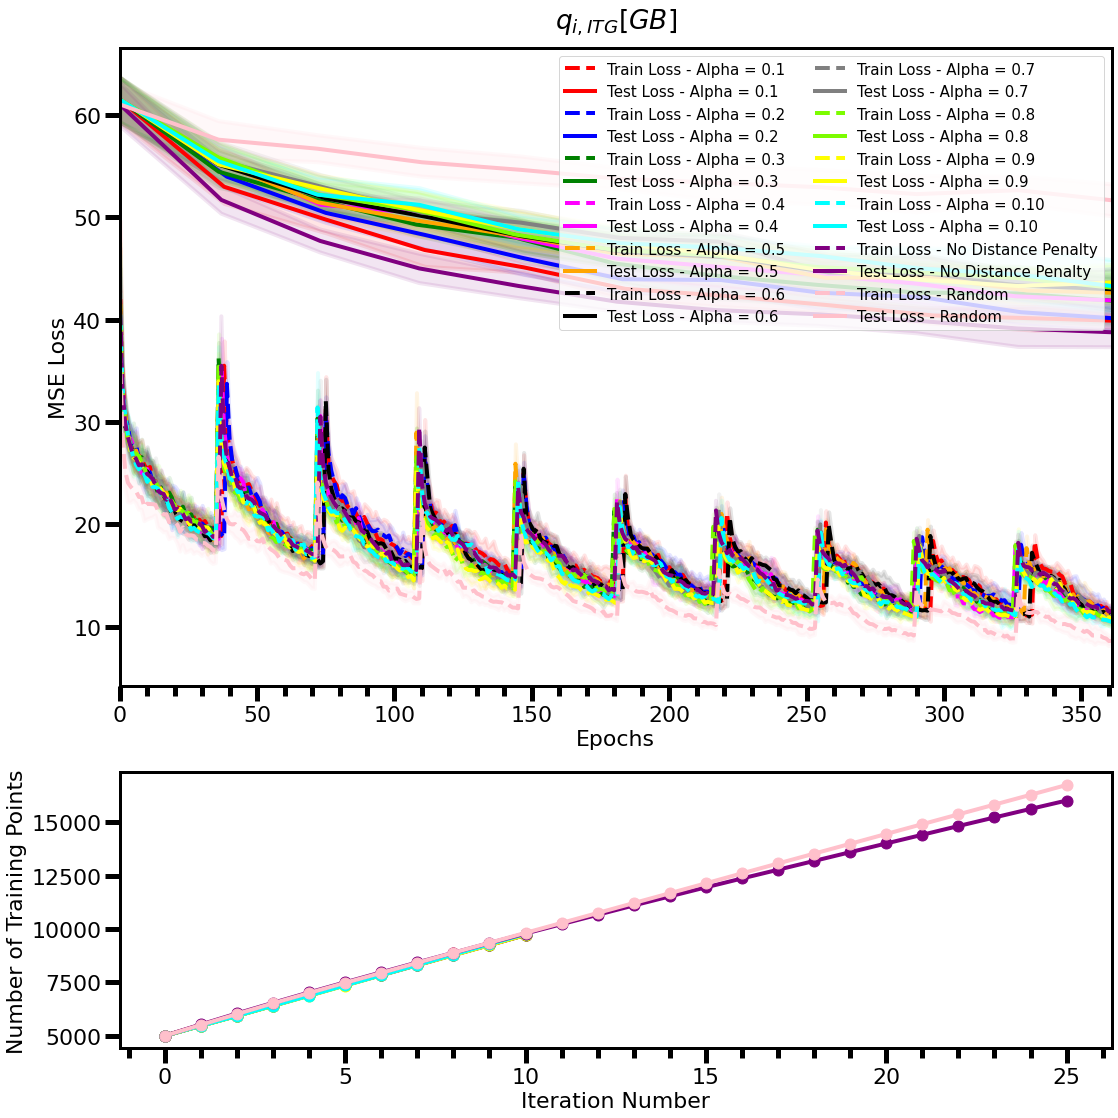

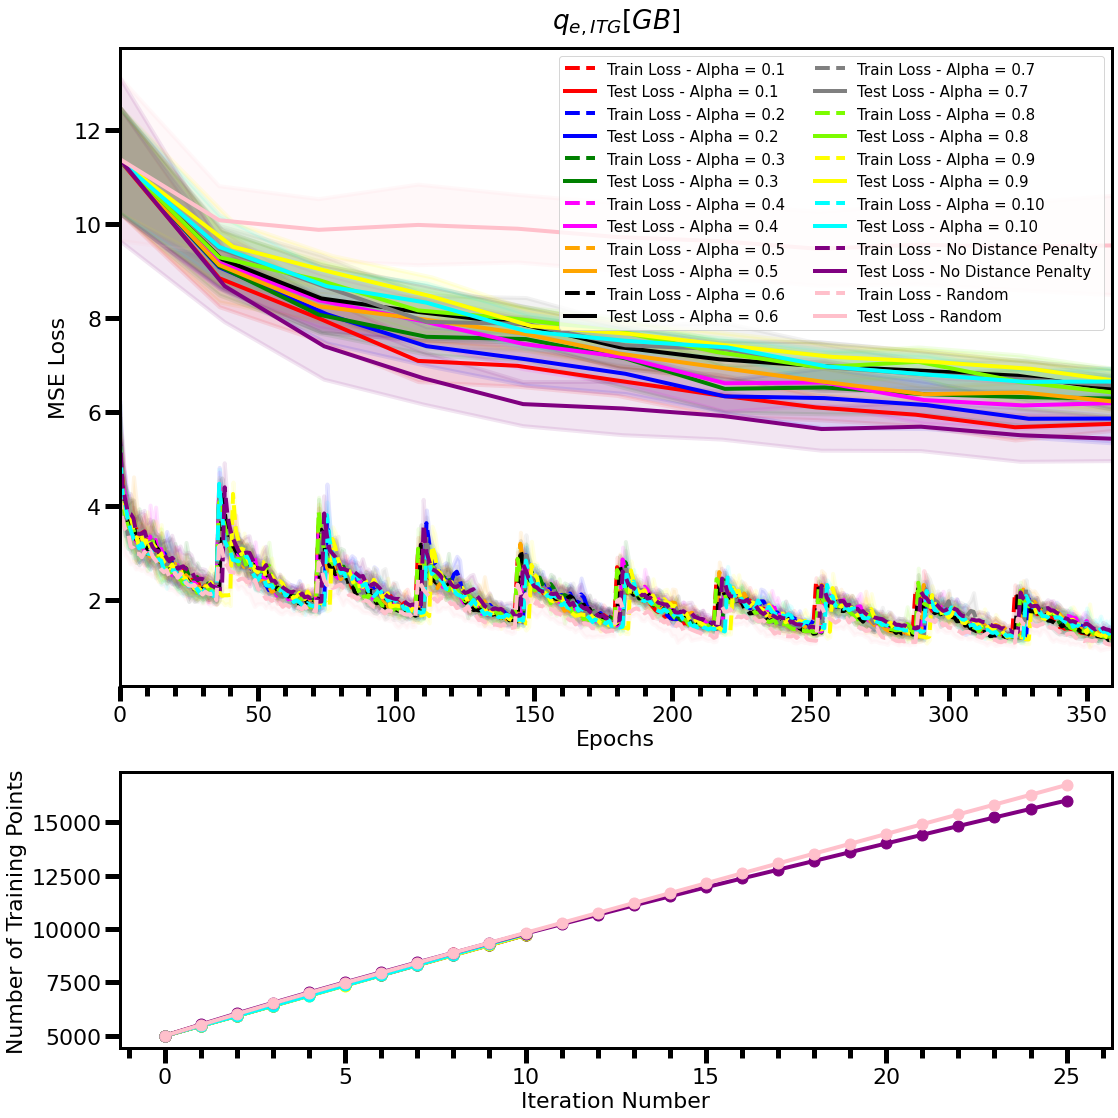

In [122]:
alphas = []

for alpha_out in alphas_out:
    alpha = collate_outputs(alpha_out, iters = 10, N = 5, initial_size = 5_000, second_flux = True, unscale = True)
    alphas.append(alpha)

strings = []
for i in range(1,11):
    strings.append(f"Alpha = 0.{i}")

alphas.append(add_5k)
strings.append("No Distance Penalty")

alphas.append(random_5k)
strings.append("Random")

plot_fig(alphas, strings, 1)
plot_fig(alphas, strings, 2)

In [114]:
betas_out = []

for i in range(1, 11):
    with open(f"/share/rcifdata/jbarr/UKAEAGroupProject/PaperFinal/beta_gamma_{i}bootstrapped_AL_lam_1_deep_classretrain_True.pkl", "rb") as f:
        out = pkl.load(f)
        betas_out.append(out)

In [107]:
with open(f"/share/rcifdata/jbarr/UKAEAGroupProject/PaperFinal/beta_gamma_1bootstrapped_AL_lam_1_deep_classretrain_True.pkl", "rb") as f:
    out = pkl.load(f)
    
with open(f"/share/rcifdata/jbarr/UKAEAGroupProject/PaperFinal/beta_gamma_2bootstrapped_AL_lam_1_deep_classretrain_True.pkl", "rb") as f:
    out2 = pkl.load(f)

In [115]:
betas[0]["test_loss_1"] == betas[1]["test_loss_1"]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

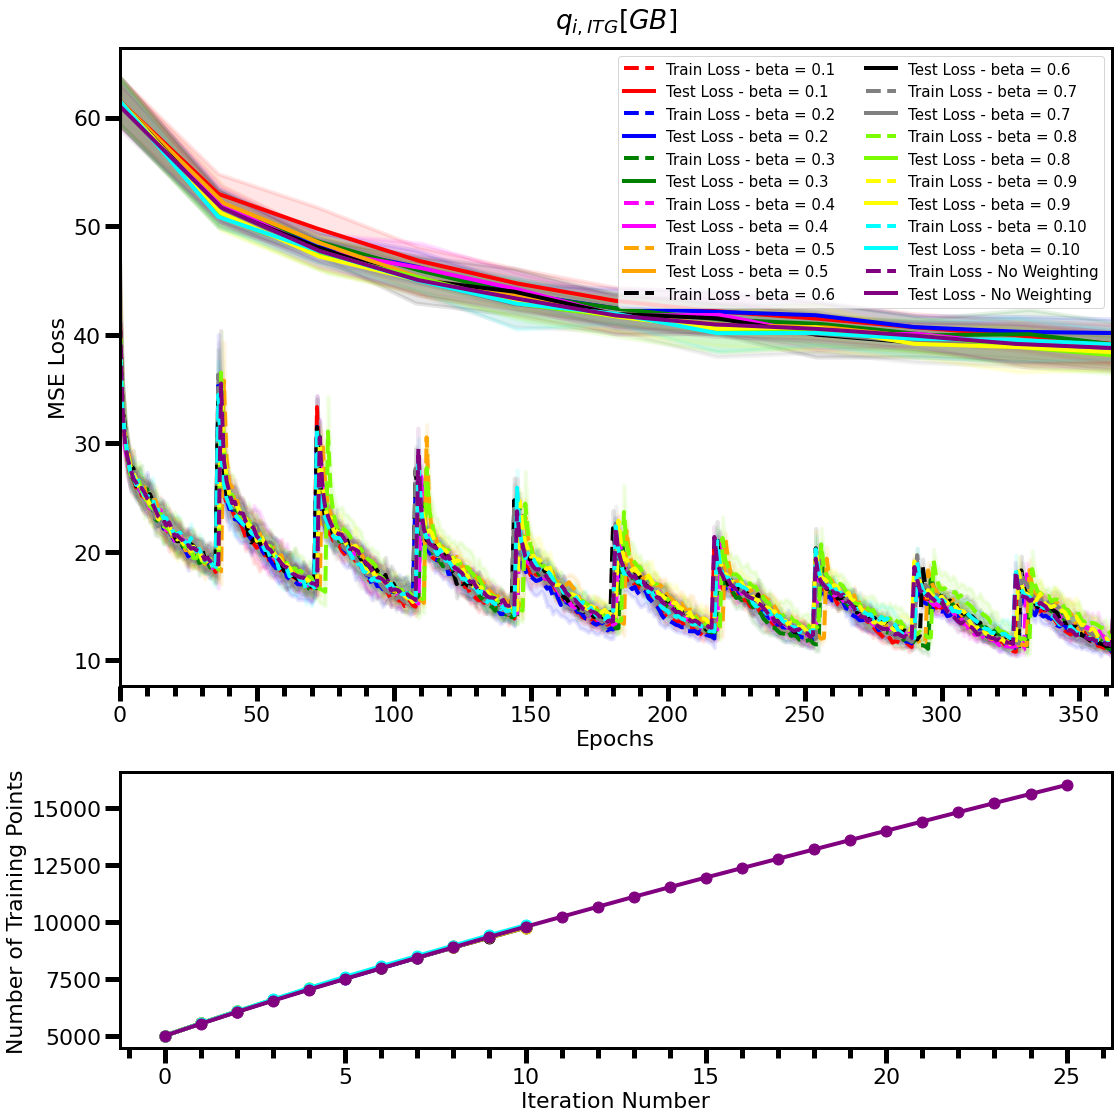

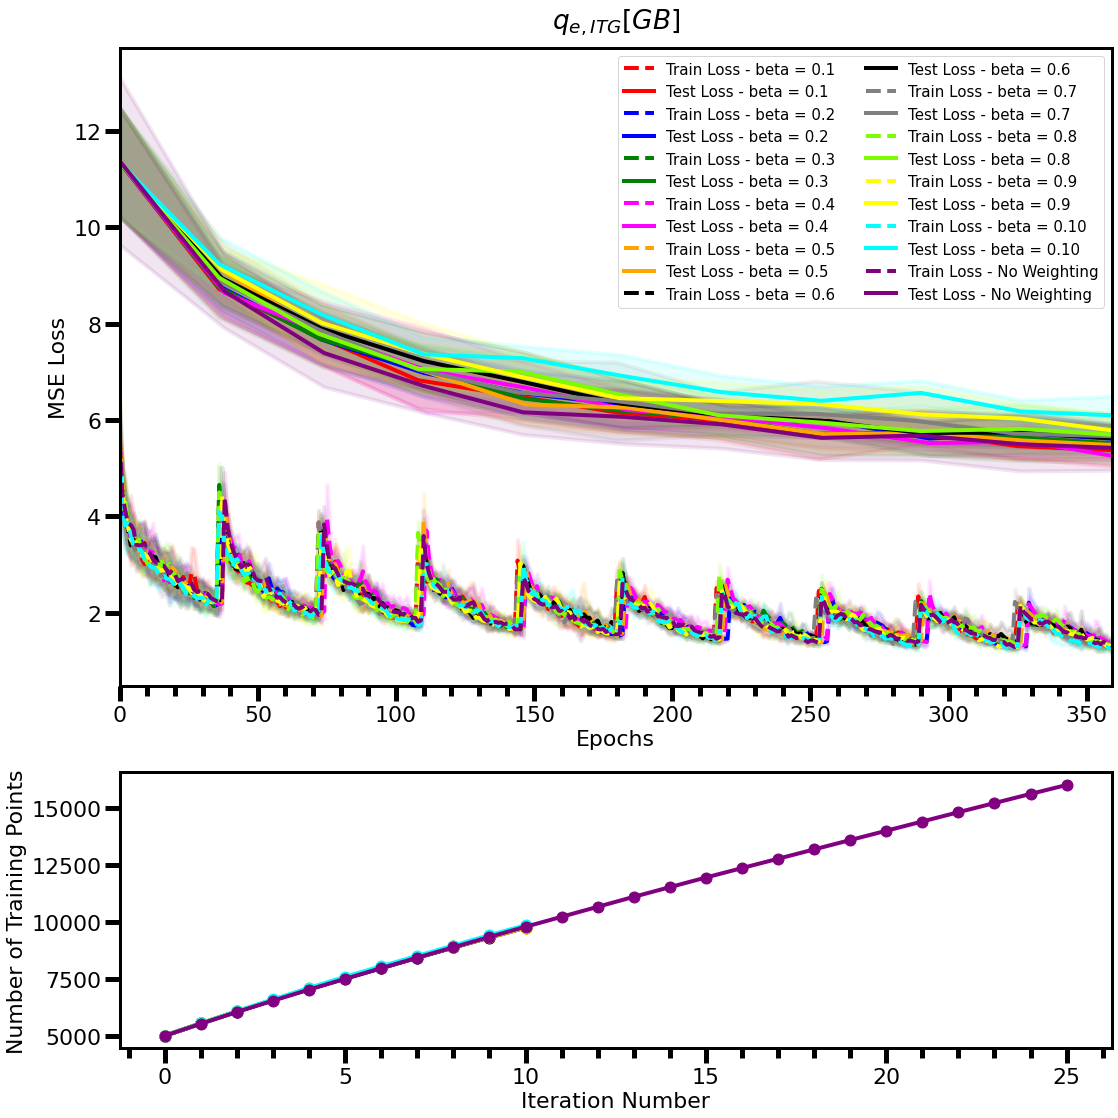

In [117]:
betas = []

for beta_out in betas_out:
    beta = collate_outputs(beta_out, iters = 10, N = 5, initial_size = 5_000, second_flux = True, unscale = True)
    betas.append(beta)

strings = []
for i in range(1,11):
    strings.append(f"beta = 0.{i}")

betas.append(add_5k)
strings.append("No Weighting")
plot_fig(betas, strings, 1)
plot_fig(betas, strings, 2)